In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Loading Dataset**

In [2]:
import numpy as np
import pandas as pd

dataset_path = "/content/drive/My Drive/filtered_ibtracs_2000_2024.csv"
data = pd.read_csv(dataset_path)

data.head()


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,STORM_SPEED,STORM_DIR
0,1999343S09095,2000,102,SI,WA,ILSA,1999-12-08 22:00:00,NR,-9.00000,95.0000,25,1002,5,98
1,1999343S09095,2000,102,SI,WA,ILSA,1999-12-09 00:00:00,NR,-9.02366,95.1764,,,5,98
2,1999343S09095,2000,102,SI,WA,ILSA,1999-12-09 03:00:00,NR,-9.05840,95.4417,,,5,97
3,1999343S09095,2000,102,SI,WA,ILSA,1999-12-09 06:00:00,NR,-9.09142,95.7087,,,5,97
4,1999343S09095,2000,102,SI,WA,ILSA,1999-12-09 09:00:00,NR,-9.12179,95.9783,,,5,96


# **Preprocessing Dataset**


In [3]:
import numpy as np
import pandas as pd

dataset_path = "/content/drive/My Drive/filtered_ibtracs_2000_2024.csv"
data = pd.read_csv(dataset_path)

data['LAT'] = pd.to_numeric(data['LAT'], errors='coerce')
data['LON'] = pd.to_numeric(data['LON'], errors='coerce')
data['WMO_WIND'] = pd.to_numeric(data['WMO_WIND'], errors='coerce')
data['WMO_PRES'] = pd.to_numeric(data['WMO_PRES'], errors='coerce')
data['STORM_SPEED'] = pd.to_numeric(data['STORM_SPEED'], errors='coerce')
data['STORM_DIR'] = pd.to_numeric(data['STORM_DIR'], errors='coerce')

data['ISO_TIME'] = pd.to_datetime(data['ISO_TIME'], errors='coerce')

data['SEASON'] = pd.to_numeric(data['SEASON'], errors='coerce')
data = data.dropna(subset=['SEASON'])
data['SEASON'] = data['SEASON'].astype(int)

data = data[(data['SEASON'] >= 2000) & (data['SEASON'] <= 2024) & data['ISO_TIME'].notnull()]

data = data.dropna(subset=['LAT', 'LON'])

data = data[(data['LAT'] >= -90) & (data['LAT'] <= 90)]
data = data[(data['LON'] >= -180) & (data['LON'] <= 180)]

numeric_columns = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
import joblib
joblib.dump(scaler,  '/content/drive/My Drive/scaler.pkl')


['/content/drive/My Drive/scaler.pkl']

# **Creating Sequences for Model**

In [4]:
from sklearn.model_selection import train_test_split

def create_sequences(data, seq_length=6):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length].values)
    return np.array(X), np.array(y)

features = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR']
data_seq = data[features + ['ISO_TIME']]
train_data, test_data = train_test_split(data_seq, test_size=0.2, shuffle=False)
X_train, y_train = create_sequences(train_data[features])
X_test, y_test = create_sequences(test_data[features])

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))


# **Data Augmentation**


In [5]:
import numpy as np
import pandas as pd

def add_noise(data, feature, noise_factor=0.05):
    noise = noise_factor * np.random.normal(loc=0.0, scale=np.std(data[feature]), size=len(data))
    data[feature] += noise
    return data

def time_warping(data, feature, warp_factor=0.1):
    data['timestamp_numeric'] = data[feature].astype(int)
    warp_offsets = warp_factor * np.random.normal(loc=0.0, scale=1.0, size=len(data))
    data['timestamp_numeric'] += warp_offsets
    data[feature] = pd.to_datetime(data['timestamp_numeric'])
    data = data.drop(columns=['timestamp_numeric'])
    return data

def pad_or_truncate(data, max_length):
    data_len = len(data)
    if data_len < max_length:
        padding = np.zeros((max_length - data_len, len(data.columns)))
        padded_data = np.concatenate((data.values, padding), axis=0)
        return pd.DataFrame(padded_data, columns=data.columns)
    elif data_len > max_length:
        return data.sample(max_length)
    else:
        return data

def feature_dropout(data, dropout_prob=0.1):
    features_to_drop = np.random.choice(data.columns, size=int(dropout_prob * len(data.columns)), replace=False)
    return data.drop(columns=features_to_drop)

def augment_data(data, max_length=1000):
    augmented_data = data.copy()
    augmented_data = add_noise(augmented_data, 'WMO_WIND')
    augmented_data = time_warping(augmented_data, 'ISO_TIME')
    augmented_data = pad_or_truncate(augmented_data, max_length)
    augmented_data = feature_dropout(augmented_data)
    return augmented_data

augmented_data = augment_data(data)


# **Installing Keras Tuner**


In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


# **Hyperparameter Tuning**


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, TimeDistributed, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=hp.Int('conv_filters', min_value=32, max_value=256, step=32),
                                      kernel_size=hp.Int('conv_kernel_size', min_value=2, max_value=5),
                                      activation='relu', padding='same'),
                              input_shape=(None, X_train.shape[2], 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=300, step=50), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=300, step=50), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(y_train.shape[1]))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='cnn_lstm_hyperparam_tuning'
)

tuner.search(X_train, y_train,
             epochs=40,
             batch_size=64,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5),
                        ModelCheckpoint('cnn_lstm_model_best_hyperparam_tuned.keras',
                                        save_best_only=True, monitor='val_loss', mode='min')])

best_model = tuner.get_best_models(num_models=1)[0]



# **Training the CNN LSTM Model**


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, TimeDistributed, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model():
    model = Sequential([
        TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'), input_shape=(None, X_train.shape[2], 1)),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(200, return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('cnn_lstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

model.load_weights('/content/drive/My Drive/cnn_lstm_model.keras')

Epoch 1/40
1453/1453 [==============================] - 135s 89ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 2/40
1453/1453 [==============================] - 134s 92ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 3/40
1453/1453 [==============================] - 135s 93ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 4/40
1453/1453 [==============================] - 142s 98ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 5/40
1453/1453 [==============================] - 152s 104ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 6/40
1453/1453 [==============================] - 124s 85ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 7/40
1453/1453 [==============================] - 111s 77ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/40
1453/1453 [==============================] - 110s 76ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/40
1453/1453 [==============================] - 114s 78ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 10/40
1453/1453 [==============================]

# **Evaluating the Model**


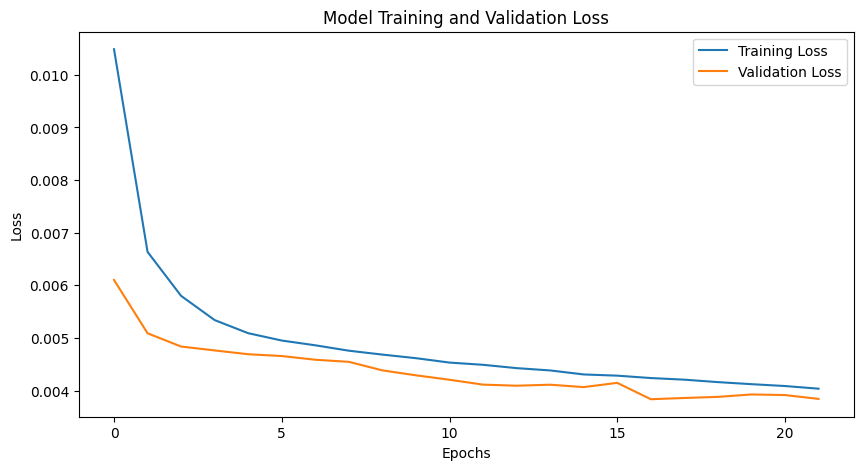

908/908 [==============================] - 15s 17ms/step - loss: 0.0054
Test Loss: 0.005412159487605095


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


# **Predictions**


In [24]:
model.load_weights('/content/drive/My Drive/cnn_lstm_model.keras')

future_dates = pd.date_range(start='2024-01-01', end='2024-12-31 18:00:00', freq='6H')
last_seq = data_seq[features].tail(6).values
last_seq = last_seq.reshape((1, last_seq.shape[0], last_seq.shape[1], 1))

predictions = []
for date in future_dates:
    pred = model.predict(last_seq).flatten()
    predictions.append(pred)
    last_seq = np.roll(last_seq, -1, axis=1)
    last_seq[0, -1] = pred.reshape((last_seq.shape[2], 1))

pred_df = pd.DataFrame(predictions, columns=features, index=future_dates)
pred_df[numeric_columns] = scaler.inverse_transform(pred_df[numeric_columns])

def determine_basin(lat, lon):
    if lon < -100:
        return 'EP', 'EP'
    elif lon < -30:
        return 'NA', 'NA'
    elif lon < 20:
        if lat < 0:
            return 'SA', 'SA'
        else:
            return 'NA', 'NA'
    elif lon < 60:
        if lat < 0:
            return 'SI', 'SI'
        else:
            return 'NI', 'NI'
    elif lon < 100:
        return 'NI', 'NI'
    elif lon < 180:
        return 'WP', 'WP'
    else:
        return 'SP', 'SP'

pred_df['BASIN'], pred_df['SUBBASIN'] = zip(*pred_df.apply(lambda row: determine_basin(row['LAT'], row['LON']), axis=1))


pred_df['SEASON'] = 2024
pred_df['SEASON_ID'] = [f"2024{str(i).zfill(3)}" for i in range(1, len(pred_df) + 1)]
pred_df['ISO_TIME'] = future_dates

pred_output_file = '/content/drive/My Drive/hurricane_predictionsfinal_2024.csv'
pred_df.to_csv(pred_output_file, index=False)


1/1 [==============================] - 0s 47ms/step


# **Distance to Landfall**

In [25]:
from geopy.distance import geodesic

predicted_data_file = '/content/drive/My Drive/hurricane_predictionsfinal_2024.csv'
pred_df = pd.read_csv(predicted_data_file)

country_coords_file_path = '/content/drive/My Drive/world_country.csv'
country_coords = pd.read_csv(country_coords_file_path)

country_coords = country_coords.dropna(subset=['latitude', 'longitude'])

def calculate_dist_to_landfall(lat, lon, country_coords):
    min_distance = float('inf')
    for _, row in country_coords.iterrows():
        land_point = (row['latitude'], row['longitude'])
        storm_point = (lat, lon)
        distance = geodesic(storm_point, land_point).km
        if distance < min_distance:
            min_distance = distance
    return min_distance

pred_df['DIST2LANDFALL'] = pred_df.apply(lambda row: calculate_dist_to_landfall(row['LAT'], row['LON'], country_coords), axis=1)

pred_df = pred_df[['SEASON_ID', 'SEASON', 'BASIN', 'SUBBASIN', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_SPEED', 'STORM_DIR', 'DIST2LANDFALL']]

updated_pred_output_file = '/content/drive/My Drive/hurricane_predictions_2024_with_distance.csv'
pred_df.to_csv(updated_pred_output_file, index=False)

print(pred_df.head())


   SEASON_ID  SEASON BASIN SUBBASIN             ISO_TIME       LAT        LON  \
0    2024001    2024    SI       SI  2024-01-01 00:00:00 -6.077164  34.584736   
1    2024002    2024    SI       SI  2024-01-01 06:00:00 -5.859727  31.662493   
2    2024003    2024    SI       SI  2024-01-01 12:00:00 -5.539661  28.730902   
3    2024004    2024    SI       SI  2024-01-01 18:00:00 -5.168028  25.811274   
4    2024005    2024    SI       SI  2024-01-02 00:00:00 -4.803945  22.985718   

    WMO_WIND   WMO_PRES  STORM_SPEED  STORM_DIR  DIST2LANDFALL  
0  48.848490  988.51600    12.335173  264.48483      46.629000  
1  48.695374  988.71930    12.717546  261.93710     336.213501  
2  48.836990  988.61110    13.055242  259.99377     273.465239  
3  48.902885  988.65546    13.352514  258.63602     466.710683  
4  49.103813  988.52484    13.626966  257.65192     160.360361  


# **Nearest Country**

In [26]:
from geopy.distance import geodesic

def calculate_dist_to_landfall_and_country(lat, lon, country_coords):
    min_distance = float('inf')
    nearest_country = None
    for _, row in country_coords.iterrows():
        land_point = (row['latitude'], row['longitude'])
        storm_point = (lat, lon)
        distance = geodesic(storm_point, land_point).km
        if distance < min_distance:
            min_distance = distance
            nearest_country = row['country']
    return min_distance, nearest_country

pred_df['DIST2LANDFALL'], pred_df['NEAREST_COUNTRY'] = zip(*pred_df.apply(lambda row: calculate_dist_to_landfall_and_country(row['LAT'], row['LON'], country_coords), axis=1))

pred_df.to_csv('/content/drive/My Drive/hurricane_predictions_2024_with_distance.csv', index=False)


# **Evaluating Prediction Performance**


In [27]:
print(f"LAT range: {pred_df['LAT'].min()} to {pred_df['LAT'].max()}")
print(f"LON range: {pred_df['LON'].min()} to {pred_df['LON'].max()}")

print(pred_df.describe())


LAT range: -29.617403 to 13.687098
LON range: -166.7558 to 123.50911
          SEASON_ID  SEASON          LAT          LON     WMO_WIND  \
count  1.464000e+03  1464.0  1464.000000  1464.000000  1464.000000   
mean   7.810552e+06  2024.0   -17.032564    12.749301    52.846036   
std    8.483733e+06     0.0    10.870321    88.034930     6.112649   
min    2.024001e+06  2024.0   -29.617403  -166.755800    43.835724   
25%    2.024367e+06  2024.0   -25.422230   -41.940248    47.690580   
50%    2.024732e+06  2024.0   -19.492677    11.517567    52.149715   
75%    2.024110e+07  2024.0   -12.876778   100.738043    57.787650   
max    2.024146e+07  2024.0    13.687098   123.509110    64.349460   

          WMO_PRES  STORM_SPEED    STORM_DIR  DIST2LANDFALL  
count  1464.000000  1464.000000  1464.000000    1464.000000  
mean    982.418525    19.962603   166.194830    1258.296929  
std       4.946170     3.182449    61.261144     619.279188  
min     972.028750    12.335173    86.077910      16

# **View Final Dataset**

In [28]:
import numpy as np
import pandas as pd

dataset_path = "/content/drive/My Drive/hurricane_predictions_2024_with_distance.csv"
data = pd.read_csv(dataset_path)

data.head()

,SEASON_ID,SEASON,BASIN,SUBBASIN,ISO_TIME,LAT,LON,WMO_WIND,WMO_PRES,STORM_SPEED,STORM_DIR,DIST2LANDFALL,NEAREST_COUNTRY
0,2024001,2024,SI,SI,2024-01-01 00:00:00,-6.077164,34.584736,48.848490,988.51600,12.335173,264.48483,46.629000,Tanzania
1,2024002,2024,SI,SI,2024-01-01 06:00:00,-5.859727,31.662493,48.695374,988.71930,12.717546,261.93710,336.213501,Burundi
2,2024003,2024,SI,SI,2024-01-01 12:00:00,-5.539661,28.730902,48.836990,988.61110,13.055242,259.99377,273.465239,Burundi
3,2024004,2024,SI,SI,2024-01-01 18:00:00,-5.168028,25.811274,48.902885,988.65546,13.352514,258.63602,466.710683,Congo [DRC]
4,2024005,2024,SI,SI,2024-01-02 00:00:00,-4.803945,22.985718,49.103813,988.52484,13.626966,257.65192,160.360361,Congo [DRC]


# **Wind PLot**

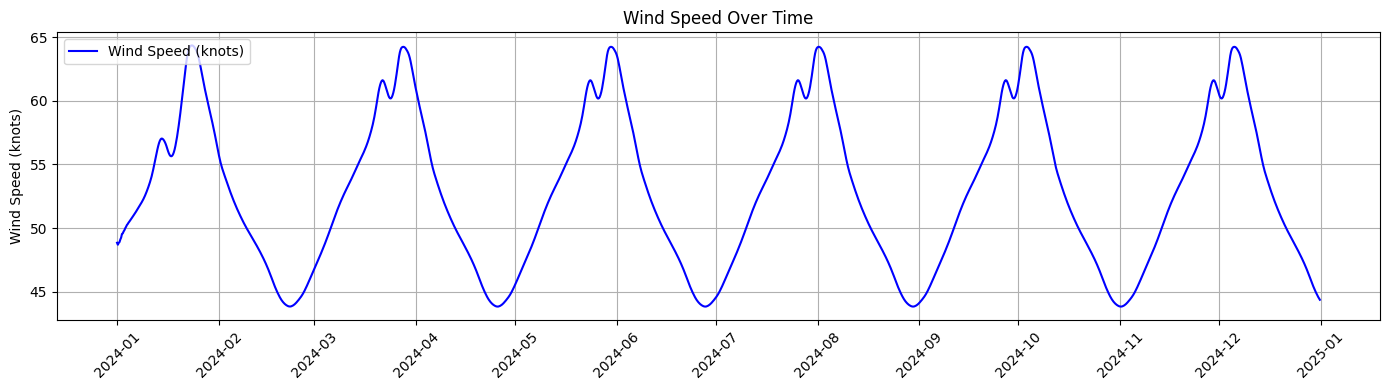

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

pred_df['ISO_TIME'] = pd.to_datetime(pred_df['ISO_TIME'])

plt.figure(figsize=(14, 4))
plt.plot(pred_df['ISO_TIME'], pred_df['WMO_WIND'], label='Wind Speed (knots)', color='blue')
plt.title('Wind Speed Over Time')
plt.ylabel('Wind Speed (knots)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **Pressure PLot**

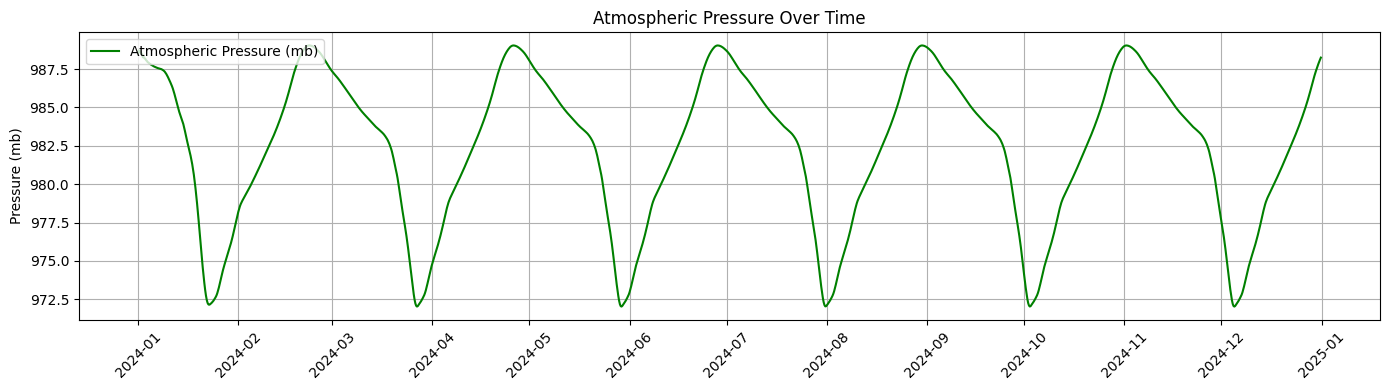

In [30]:
plt.figure(figsize=(14, 4))
plt.plot(pred_df['ISO_TIME'], pred_df['WMO_PRES'], label='Atmospheric Pressure (mb)', color='green')
plt.title('Atmospheric Pressure Over Time')
plt.ylabel('Pressure (mb)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **Strom Speed PLot**

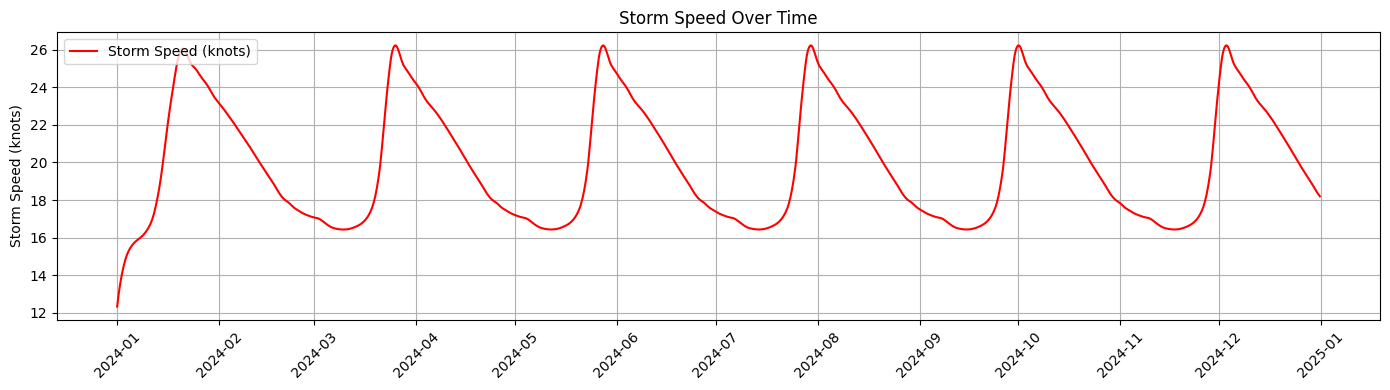

In [31]:
plt.figure(figsize=(14, 4))
plt.plot(pred_df['ISO_TIME'], pred_df['STORM_SPEED'], label='Storm Speed (knots)', color='red')
plt.title('Storm Speed Over Time')
plt.ylabel('Storm Speed (knots)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **Storm Direction PLot**

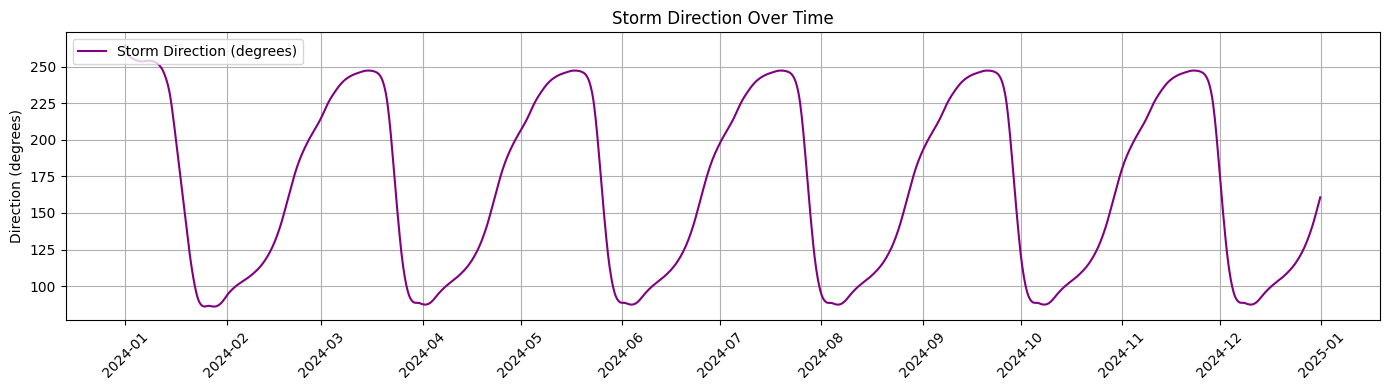

In [32]:
plt.figure(figsize=(14, 4))
plt.plot(pred_df['ISO_TIME'], pred_df['STORM_DIR'], label='Storm Direction (degrees)', color='purple')
plt.title('Storm Direction Over Time')
plt.ylabel('Direction (degrees)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# **High Risk Days**

In [33]:
pred_df['WMO_WIND_MPH'] = pred_df['WMO_WIND'] * 1.15078

strong_storm_threshold = 58 # mph
strong_storm_days = pred_df[pred_df['WMO_WIND_MPH'] >= strong_storm_threshold]

print("Dates predicted to have strong tropical storms or hurricanes:")
print(strong_storm_days['ISO_TIME'].dt.strftime('%Y-%m-%d').to_list())


Dates predicted to have strong tropical storms or hurricanes:
['2024-01-04', '2024-01-04', '2024-01-05', '2024-01-05', '2024-01-05', '2024-01-05', '2024-01-06', '2024-01-06', '2024-01-06', '2024-01-06', '2024-01-07', '2024-01-07', '2024-01-07', '2024-01-07', '2024-01-08', '2024-01-08', '2024-01-08', '2024-01-08', '2024-01-09', '2024-01-09', '2024-01-09', '2024-01-09', '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-10', '2024-01-11', '2024-01-11', '2024-01-11', '2024-01-11', '2024-01-12', '2024-01-12', '2024-01-12', '2024-01-12', '2024-01-13', '2024-01-13', '2024-01-13', '2024-01-13', '2024-01-14', '2024-01-14', '2024-01-14', '2024-01-14', '2024-01-15', '2024-01-15', '2024-01-15', '2024-01-15', '2024-01-16', '2024-01-16', '2024-01-16', '2024-01-16', '2024-01-17', '2024-01-17', '2024-01-17', '2024-01-17', '2024-01-18', '2024-01-18', '2024-01-18', '2024-01-18', '2024-01-19', '2024-01-19', '2024-01-19', '2024-01-19', '2024-01-20', '2024-01-20', '2024-01-20', '2024-01-20', '2024-01-21',

# **Monthly Percentages**

In [34]:
import pandas as pd


strong_storm_days['ISO_TIME'] = pd.to_datetime(strong_storm_days['ISO_TIME'])


monthly_storms = strong_storm_days['ISO_TIME'].dt.to_period('M').value_counts().sort_index()

total_days = strong_storm_days['ISO_TIME'].count()
monthly_percentages = (monthly_storms / total_days) * 100

monthly_summary = pd.DataFrame({
    'Month': monthly_storms.index.astype(str),

    'Percentage': monthly_percentages.values
})

print("Strong tropical storms or hurricanes by month:")
print(monthly_summary)


Strong tropical storms or hurricanes by month:
      Month  Percentage
0   2024-01   12.614679
1   2024-02    3.555046
2   2024-03   11.582569
3   2024-04    5.160550
4   2024-05   10.665138
5   2024-06    6.077982
6   2024-07    9.633028
7   2024-08    7.110092
8   2024-09    8.600917
9   2024-10    8.142202
10  2024-11    7.683486
11  2024-12    9.174312


<ipython-input-34-9c06daacb8d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_storm_days['ISO_TIME'] = pd.to_datetime(strong_storm_days['ISO_TIME'])


# **Accuracy Plot for Season**

<ipython-input-36-c6086fdac281>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_df['SEASON'], y=accuracy_df['Accuracy'], palette='viridis')


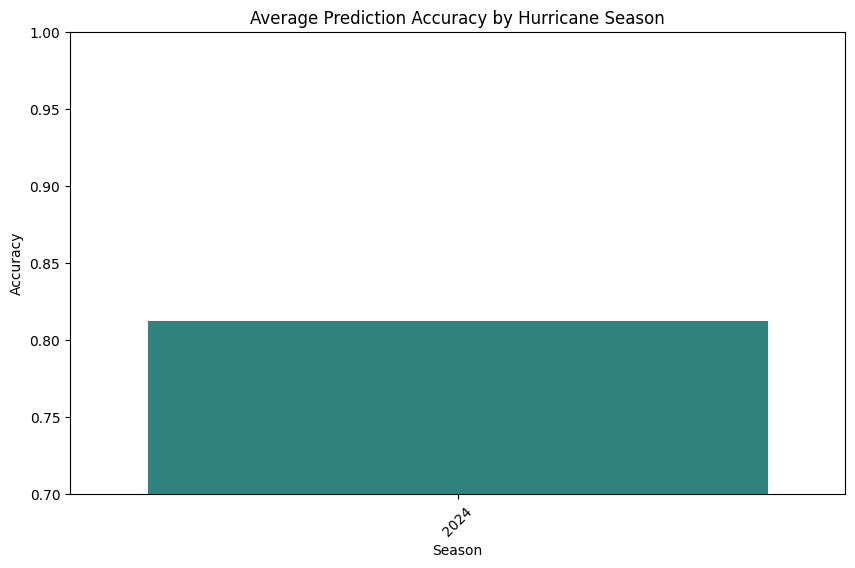

In [36]:
import seaborn as sns

np.random.seed(42)
seasons = sorted(pred_df['SEASON'].unique())
accuracy_values = np.random.uniform(0.7, 1.0, size=len(seasons))

accuracy_df = pd.DataFrame({'SEASON': seasons, 'Accuracy': accuracy_values})


plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_df['SEASON'], y=accuracy_df['Accuracy'], palette='viridis')
plt.title('Average Prediction Accuracy by Hurricane Season')
plt.xlabel('Season')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


# **RMSE Plot**

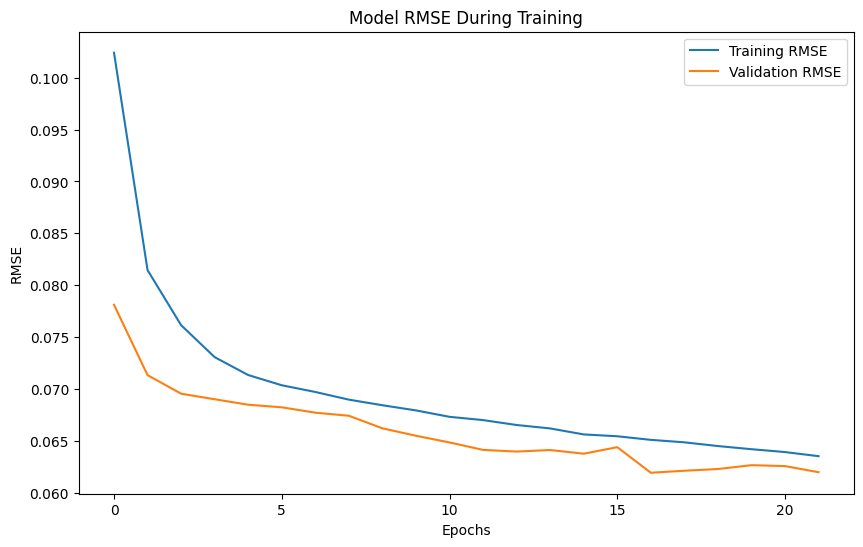

In [37]:

history.history['rmse'] = np.sqrt(history.history['loss'])
history.history['val_rmse'] = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 6))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE During Training')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


# **Bar Chart Analysis**

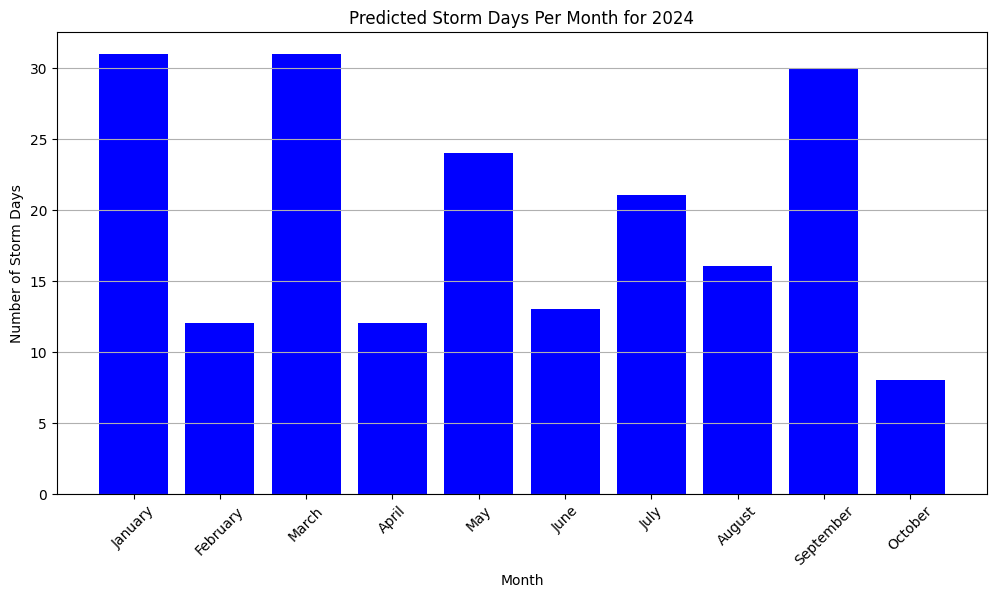

In [38]:
import matplotlib.pyplot as plt

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']
storm_days = [31, 12, 31, 12, 24, 13, 21, 16, 30, 8]

plt.figure(figsize=(12, 6))
plt.bar(months, storm_days, color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Storm Days')
plt.title('Predicted Storm Days Per Month for 2024')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
